# Read the Data

In [15]:
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectFromModel
import warnings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

warnings.filterwarnings('ignore')

In [16]:
df_main = pd.read_csv('xtrain.txt', header = None, sep = '\t', index_col = 0)
# df_main.set_index(0, inplace = True)
df_main = df_main.transpose()
df_main.head()

# Read the y values
df_y = pd.read_csv('ytrain.txt', header = None)
# df_y.index = 1+np.arange(184)

# # Concatenate both
# df_main['y'] = df_y[0:]
# df_main = df_main.astype({'y':'category'})

df_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 1 columns):
0    184 non-null int64
dtypes: int64(1)
memory usage: 1.5 KB


In [3]:
# Save the data
# df_main.to_csv('breast_genes.csv', index = False)

In [30]:
from sklearn.linear_model import Lasso

lass = Lasso(
        max_iter=3000,
        alpha= 0.00281,
        random_state= 5 
        )
lass.fit(x, y)
lass.coef_.min(), lass.coef_.max()

#Checking Features Importances
import matplotlib
coef = pd.Series(lass.coef_, index = df_main.columns)
#print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


# imp_coef = pd.concat([coef.sort_values().head(25),
#                      coef.sort_values().tail(25)])
# matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
# imp_coef.plot(kind = "barh")
# plt.title("Coefficients in the Lasso Model")

# Selection of features
good_features = np.abs(np.array(lass.coef_)) > 0

sum(good_features)
# print("Features reduced from %10d to %10d" % (train_norm.shape[1], int(good_features.sum())))
# #saving data
# train_lasso_select = train.iloc[:, good_features]
# test_lasso_select= test.iloc[:, good_features]
# train_lasso_select.to_csv('train_lasso_select.csv',index=False)
# test_lasso_select.to_csv('test_lasso_select.csv',index=False)

df_lasso = df_main.iloc[:, good_features]


# Applying Different Models

In [31]:
x = df_lasso.values
y = np.array(df_y.values)

scaler = preprocessing.StandardScaler()

# x = scaler.fit_transform(x)
# x = preprocessing.MinMaxScaler().fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, shuffle=True)

In [32]:
def train(model, xtrain, ytrain, xtest, ytest):
    
    model.fit(xtrain, ytrain)
    pred = model.predict(xtest)
    kfold = KFold(n_splits=10, random_state=42)
    result = cross_val_score(model, xtrain, ytrain, cv=kfold, scoring='balanced_accuracy')
    print(f'Accuracy =  {model.score(xtest, ytest):.4} - ROC = {roc_auc_score(ytest, pred):.4} - CV mean = {result.mean():.4}')
    

In [33]:
# Random Forest with default number of estimators
rf = RandomForestClassifier(random_state=42)
train(rf, x_train, y_train, x_test, y_test)


Accuracy =  0.5574 - ROC = 0.4731 - CV mean = 0.6186


In [34]:
lgb = LGBMClassifier()
train(lgb, x_train, y_train, x_test, y_test)

Accuracy =  0.6721 - ROC = 0.6081 - CV mean = 0.5661


In [35]:
# RandomForest with 100 estimators
rf = RandomForestClassifier(n_estimators= 100, random_state=42)
train(rf, x_train, y_train, x_test, y_test)

Accuracy =  0.6393 - ROC = 0.5303 - CV mean = 0.5043


In [36]:
# SVM with default parameters
clf = SVC(random_state=42)
train(clf, x_train, y_train, x_test, y_test)

Accuracy =  0.623 - ROC = 0.5 - CV mean = 0.5


In [37]:
# SVM with default parameters
clf = LinearSVC(random_state=42)
train(clf, x_train, y_train, x_test, y_test)

Accuracy =  0.9508 - ROC = 0.9348 - CV mean = 0.8608


In [38]:
# Logistic Regression with default parameters
lr = LogisticRegression(random_state=42)
train(lr, x_train, y_train, x_test, y_test)

Accuracy =  0.9344 - ROC = 0.9216 - CV mean = 0.782


In [39]:
# Logistic Regression with dual form 
lr = LogisticRegression(random_state=42, dual =True) # best one till now
train(lr, x_train, y_train, x_test, y_test)

Accuracy =  0.9344 - ROC = 0.9216 - CV mean = 0.7989


In [40]:
# Logistic Regression with C = 0.01
# C : Inverse of regularization strength; must be a positive float. 
# Like in support vector machines, smaller values specify stronger regularization.

lr = LogisticRegression(random_state=42, C = 0.01)
train(lr, x_train, y_train, x_test, y_test)

Accuracy =  0.8197 - ROC = 0.7695 - CV mean = 0.6442


In [41]:
# KNN with default params
knn = KNeighborsClassifier()
train(knn, x_train, y_train, x_test, y_test)

Accuracy =  0.6557 - ROC = 0.6035 - CV mean = 0.5841


In [42]:
# SVM with polynomial kernel
clf = SVC(random_state=42 , C = 10, kernel = 'poly') # (sigmoid 62) and (rbf 65), (poly 70)
train(clf, x_train, y_train, x_test, y_test)

Accuracy =  0.9344 - ROC = 0.9216 - CV mean = 0.8186


# Hyperparams Tuning for SVM

## SVM

In [77]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 100]
#     gammas = [0.001, 0.01, 0.1, 1]
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    degrees = [2, 3, 4, 5]
    param_grid = {'C': Cs, 'kernel' : kernels, 'degree': degrees}
    grid_search = GridSearchCV(SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [78]:
# takes 4 min to run
best_params = svc_param_selection(x_train, y_train, 10)
best_params # were {'C': 0.01, 'degree': 2, 'kernel': 'linear'}

{'C': 0.01, 'degree': 2, 'kernel': 'linear'}

In [79]:
clf = SVC(random_state=42 , C= 0.01, degree= 2, kernel= 'linear')
train(clf, x_train, y_train, x_test, y_test)

Accuracy =  0.9508 - ROC = 0.9348 - CV mean = 0.8608


In [46]:
clf = SVC(random_state=42 , C = 10, kernel = 'poly', degree = 7) 
train(clf, x_train, y_train, x_test, y_test)

Accuracy =  0.8852 - ROC = 0.8736 - CV mean = 0.7595


## Logistic Regression

In [72]:
def lr_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 100]
    dual = [False, True]
#     solvers = [ 'liblinear'] 
#     reg = ['l1', 'l2']
    param_grid = {'C': Cs ,
                  'dual': dual
                 }

    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


In [76]:
best_lr_params = lr_param_selection(x_train, y_train, 10)
best_lr_params # were {'C': 0.001, 'dual': False, 'solver': 'newton-cg'}
lr = LogisticRegression(random_state=42, C = 10, dual= False)
train(lr, x_train, y_train, x_test, y_test)

Accuracy =  0.9344 - ROC = 0.9216 - CV mean = 0.7987


# Genetic Algorithm for choosing the best pipeline

In [22]:
# from tpot import TPOTClassifier

In [23]:
# auto_ml = TPOTClassifier(generations = 20, population_size = 100, scoring = 'balanced_accuracy', n_jobs = 4, random_state = 42, warm_start = True, verbosity = 2)
# auto_ml.fit(x_train, y_train)

In [24]:
# auto_ml.export('tpot_exported_pipeline.py')

In [25]:
# Best pipeline: 
# DecisionTreeClassifier(Normalizer(input_matrix, norm=max), criterion=gini, max_depth=6, min_samples_leaf=4, min_samples_split=4)

# Visualization

 ## PCA

(184, 3)


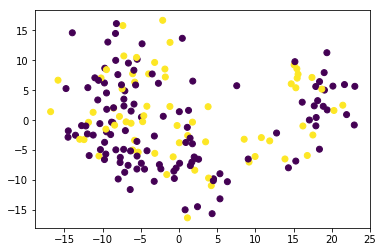

In [60]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x)
print(pca_result.shape)
df = df_main.copy()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]


plt.scatter(df['pca-one'], df['pca-two'], c = df_y.values.reshape(-1,))

In [61]:
pca = PCA(n_components=184)
pca.fit(x, y)

PCA(copy=True, iterated_power='auto', n_components=184, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [62]:
pca.components_.shape

(184, 184)

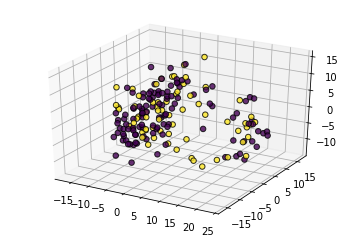

In [65]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
ax.scatter(df['pca-one'], df['pca-two'], df['pca-three'], alpha=0.8, c=df_y.values.reshape(-1,), edgecolors='none', s=30)

## t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 184 samples in 0.000s...
[t-SNE] Computed neighbors for 184 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 184 / 184
[t-SNE] Mean sigma: 10.232167
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.275612
[t-SNE] KL divergence after 300 iterations: 1.127516


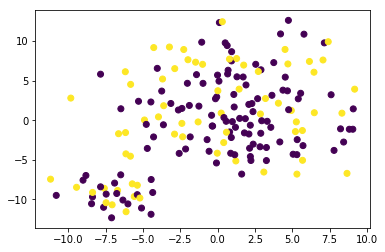

In [69]:
n_sne = 7000

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)

plt.scatter(tsne_results[:,0], tsne_results[:,1], c = df_y.values.reshape(-1,))

## ISOMAP

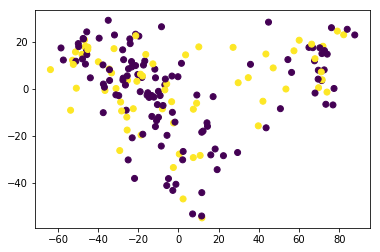

In [71]:
n_neighbors = 10
n_components = 2
y_iso = Isomap(n_neighbors, n_components).fit_transform(x)

ax = fig.add_subplot(111)
plt.scatter(y_iso[:, 0], y_iso[:, 1], c=y.reshape(-1,))#, cmap=plt.cm.Spectral)

plt.axis('tight')
plt.show()

# Feature selection

## F-Test

F-Test is useful in feature selection as we get to know the significance of each feature in improving the model.

In [49]:
F, pval = f_classif(x, y)
idx = np.argsort(-F)
idx

array([  4,  19, 174, 151,  32, 112, 143,  46, 134, 133, 120,  10,   3,
        57, 179,  78, 144,  37,  73, 148,  59,   2, 178,  29, 161,  44,
       181,  47,   6, 125,  33,  51, 180,  12, 136, 182,  31,  62,  95,
       108, 124, 157, 135,  48,  76, 118,  23,  26, 145,  36,  16,  65,
        68,  80,  60,  97, 109, 132,  25,  92, 140,  79,  52,  58,  56,
       155,  35, 139,  11, 170, 156, 121, 166, 169,  67,  21, 138,   0,
        15, 150, 126, 149, 130,  39, 129, 146,  40,  17,  69, 110,  30,
        42, 101,  13, 172, 159, 183,  53,  55,  93, 106, 117,  77, 105,
         7,  86, 152,  89,  41,  91,  71, 107,  22, 168,  84, 141,  74,
        72, 115, 173, 176,  34, 111, 102,  81, 137,  43, 116,   1,  90,
       114, 142, 154, 123, 103,   5,  98,  18, 153,  50, 175, 104,  63,
       100,  87,  61, 127,  20, 177,  82,  75, 158,  24, 163,   9, 119,
        64,  70, 164,  66,  85,  45,  14,  49, 131,  28, 122, 167, 160,
       171,   8,  88,  27,  54, 128,  99,  96, 162, 165,  83,  3

In [54]:
df_new = df_lasso.iloc[:,idx[0:100]]
# df_new['y'] = df_y[0:]

# x_red = df_new.drop(['y'], axis = 1).values
y_red = np.array(df_y.values)

# df_new.head()
x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x_red, y_red, test_size=0.33, random_state=42)

In [55]:
lr = LogisticRegression(random_state=42, dual =True) # best one till now
train(lr, x_train_red, y_train_red, x_test_red, y_test_red)

# xgb = XGBClassifier(learning_rate=0.1, n_estimators=100)
# train(xgb, x_train_red, y_train_red, x_test_red, y_test_red)

Accuracy =  0.7869 - ROC = 0.7431 - CV mean = 0.7825


In [56]:
# best_params = svc_param_selection(x_train_red, y_train_red, 10)
# best_params # were {'C': 0.001, 'degree': 5, 'kernel': 'poly'}
clf = SVC(C = 0.001, kernel = 'poly', degree = 5)
train(clf, x_train_red, y_train_red, x_test_red, y_test_red)

Accuracy =  0.7705 - ROC = 0.7557 - CV mean = 0.76


In [40]:
# num_feats = np.linspace(100, 3000, 30)

# for f in num_feats:
#     df_new = df_main.iloc[:,idx[0:int(f)]]
#     df_new['y'] = df_y[0:]

#     x_red = df_new.drop(['y'], axis = 1).values
#     y_red = np.array(df_new.y.values)

#     x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x, y, test_size=0.33, random_state=42)

#     lr = LogisticRegression(random_state=42, dual =True) # best one till now
#     lr.fit(x_train_red, y_train_red)
#     pred = lr.predict(x_test_red)
#     print(f'for num_feats = {f} - Accuracy = {lr.score(x_test, y_test):.4f} - ROC = {roc_auc_score(y_test, pred):.4f}')


## Mututal Information

In [41]:
mi = mutual_info_classif(x, y)

In [42]:
mi.shape

(4654,)

In [43]:
idx_mi = np.argsort(-mi)
idx_mi

array([3985, 4456, 3100, ..., 1417, 3044,    0])

In [108]:
df_new = df_main.iloc[:,idx_mi[0:100]]
df_new['y'] = df_y[0:]

x_red = df_new.drop(['y'], axis = 1).values
y_red = np.array(df_new.y.values)

x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x_red, y_red, test_size=0.33, random_state=42)

lr = LogisticRegression(random_state=42, dual =True) # best one till now
train(lr, x_train_red, y_train_red, x_test_red, y_test_red)
kfold = KFold(n_splits=10, random_state=42)
result = cross_val_score(lr, x_train_red, y_train_red, cv=kfold, scoring='balanced_accuracy')
result.mean()

Accuracy =  0.7049 - ROC = 0.7288


0.58285714285714285

## Chi

In [45]:
from sklearn.feature_selection import chi2

In [107]:
chi_scores, _ = chi2(x, y)

idx_chi = np.argsort(-chi_scores)
df_new = df_main.iloc[:,idx_chi[0:100]]
df_new['y'] = df_y[0:]

x_red = df_new.drop(['y'], axis = 1).values
y_red = np.array(df_new.y.values)

x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x_red, y_red, test_size=0.33, random_state=42)

lr = LogisticRegression(random_state=42, dual =True) # best one till now
train(lr, x_train_red, y_train_red, x_test_red, y_test_red)

kfold = KFold(n_splits=10, random_state=42)
result = cross_val_score(lr, x_train_red, y_train_red, cv=kfold, scoring='balanced_accuracy')
result.mean()

Accuracy =  0.7213 - ROC = 0.6819


0.71640873015873019

## Variance Threshold

In [47]:
from sklearn.feature_selection import VarianceThreshold

In [48]:
sel = VarianceThreshold()
selected_feats = sel.fit_transform(x)

In [49]:
selected_feats.shape

(184, 4654)

## Other

In [110]:
# clf = Pipeline([
#   ('feature_selection', SelectFromModel(LassoCV())),
#   ('classification', RandomForestClassifier())
# ])

ls = LassoCV()
ls.fit(x_train, y_train)
train(ls, x_train, y_train, x_test, y_test)

# train(lr, x_train_red, y_train_red, x_test_red, y_test_red)

Accuracy =  -0.06459 - ROC = 0.4153


In [112]:
# from sklearn.feature_selection import RFECV
# model = LogisticRegression() 
# rfe = RFECV(model, 3)

# fit = rfe.fit(x_train, y_train)

In [114]:
# fit.min_features_to_select

1

In [115]:
from sklearn.linear_model import SGDClassifier
tuned_parameters = {'alpha': [10 ** a for a in range(-6, -2)]}
sgd = SGDClassifier(loss='log', penalty='elasticnet',l1_ratio=0.15, n_iter=5, shuffle=True, verbose=False, n_jobs=10, average=False, class_weight='balanced')
clf = GridSearchCV(SGDClassifier('log')
                  , tuned_parameters, cv=10, scoring='balanced_accuracy')

#now clf is the best classifier found given the search space
train(clf, x_train_red, y_train_red, x_test_red, y_test_red)
#you can find the best alpha here
print(clf.best_params_)   


Accuracy =  0.6556 - ROC = 0.6556
{'alpha': 1e-05}


In [159]:
# sgd.fit(x_train_red, y_train_red)
# sgd.coef_.shape
# np.argsort(-sgd.coef_)

# Feature Engineering

In [52]:
import featuretools as ft

In [53]:
df = df.reset_index()

In [54]:
es = ft.EntitySet(id='main_df')

In [55]:
es = es.entity_from_dataframe(entity_id= 'main_df', dataframe=df)#, make_index=False)

2019-01-31 21:34:54,859 featuretools.entityset - WARNING    ('Using first column as index. ', 'To change this, specify the index parameter')
